In [1]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from pandas.api.types import is_numeric_dtype
from datetime import datetime, timedelta
building_repo = BuildingRepository()
df = pd.DataFrame(building_repo.get_power_historic(datetime.now()-timedelta(days=30)))
df = df.drop("_id", axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index("datetime", inplace=True)
df = df.resample('15T').mean()
df["datetime"] = df.index

df['totalpower'] = pd.to_numeric(df['totalpower'], errors='coerce')
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Weekday'] = df['datetime'].dt.weekday

df.rename(columns={'totalpower': 'Consumption'}, inplace=True)
df.drop(['datetime', 'totalgeneration'], axis=1, inplace=True)

df = df.dropna()
df['Consumption-1'] = df['Consumption'].shift(1)
df.loc[df['Day'] != df['Day'].shift(1), 'Consumption-1'] = 0
df['Consumption-2'] = df['Consumption'].shift(2)
df.loc[df['Day'] != df['Day'].shift(2), 'Consumption-2'] = 0
#df = df[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
df = df[['Month', 'Day', 'Hour', 'Weekday', 'Consumption-1', 'Consumption-2', 'Consumption']]
df

,Month,Day,Hour,Weekday,Consumption-1,Consumption-2,Consumption
0,10,8,16,6,0.0000,0.0000,1550.0000
1,10,8,16,6,1550.0000,0.0000,1158.0000
2,10,8,16,6,1158.0000,1550.0000,1570.0000
3,10,8,16,6,1570.0000,1158.0000,1170.0000
4,10,8,16,6,1170.0000,1570.0000,1560.0000
...,...,...,...,...,...,...,...
794418,11,7,16,1,2084.2000,3052.0000,3062.0000
794419,11,7,16,1,3062.0000,2084.2000,2036.9998
794420,11,7,16,1,2036.9998,3062.0000,3033.0000
794421,11,7,16,1,3033.0000,2036.9998,2041.0000


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Data preprocessing - Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
pred_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = pred_scaler.fit_transform(np.array(df['Consumption']).reshape(-1, 1))

# split into train and test sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]
print("Len train", len(train), "Len test", len(test))

Len train 635538 Len test 158885


In [3]:
import joblib

# Assuming you have a scaler object named 'scaler'
joblib.dump(scaler, 'training_1/scaler.pkl')
joblib.dump(pred_scaler, 'training_1/pred_scaler.pkl')

['training_1/pred_scaler.pkl']

In [4]:
import numpy as np

# Prepare data for LSTM (sequence-to-sequence)
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)


timesteps = 1
X_train, y_train = prepare_data(train, timesteps)
X_test, y_test = prepare_data(test, timesteps)

print("X_train shape", X_train.shape, "timesteps", timesteps)
print("X_test shape", X_test.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[2]))

print("X_train shape", X_train.shape, "y_train shape", y_train.shape)
print("X_test shape", X_test.shape, "y_test shape", y_test.shape)

X_train shape (635535, 1, 6) timesteps 1
X_test shape (158882, 1, 6) timesteps 1
X_train shape (635535, 1, 6) y_train shape (635535,)
X_test shape (158882, 1, 6) y_test shape (158882,)


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

def create_model():
    # LSTM model
    model = Sequential()
    print(timesteps, X_train.shape[2])
    model.add(LSTM(units=4, input_shape=(timesteps, X_train.shape[2])))
    model.add(Dense(units=1))  # Use the original number of features as the output units
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae', 'mse'])

    return model

model = create_model()

# Display the model's architecture
model.summary()

2023-11-07 16:05:08.256475: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 16:05:08.294589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 16:05:08.294879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 16:05:08.979792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 6


2023-11-07 16:05:09.570736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 16:05:09.571184: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 176       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=4, batch_size=7, verbose=1, callbacks=[cp_callback])

Epoch 1/4
90786/90791 [============================>.] - ETA: 0s - loss: 2.6932e-04 - mae: 0.0059 - mse: 2.6932e-04
Epoch 1: saving model to training_1/cp.ckpt
90791/90791 [==============================] - 341s 4ms/step - loss: 2.6931e-04 - mae: 0.0059 - mse: 2.6931e-04
Epoch 2/4
90789/90791 [============================>.] - ETA: 0s - loss: 1.5914e-04 - mae: 0.0048 - mse: 1.5914e-04
Epoch 2: saving model to training_1/cp.ckpt
90791/90791 [==============================] - 225s 2ms/step - loss: 1.5914e-04 - mae: 0.0048 - mse: 1.5914e-04
Epoch 3/4
90779/90791 [============================>.] - ETA: 0s - loss: 1.5759e-04 - mae: 0.0047 - mse: 1.5759e-04
Epoch 3: saving model to training_1/cp.ckpt
90791/90791 [==============================] - 192s 2ms/step - loss: 1.5767e-04 - mae: 0.0047 - mse: 1.5767e-04
Epoch 4/4
90784/90791 [============================>.] - ETA: 0s - loss: 1.5623e-04 - mae: 0.0046 - mse: 1.5623e-04
Epoch 4: saving model to training_1/cp.ckpt
90791/90791 [===========

In [7]:
y_test

array([0.05441228, 0.10620858, 0.05441228, ..., 0.3768748 , 0.19811647,
       0.37181724])

In [8]:
# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

model.save('saved_model/consumption_forecast')

y_train_inv = pred_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = pred_scaler.inverse_transform(y_test.reshape(-1, 1))

# Make predictions on train and test sets
y_train_pred = model.predict(X_train)
y_train_pred = pred_scaler.inverse_transform(y_train_pred)

y_test_pred = model.predict(X_test)
y_test_pred = pred_scaler.inverse_transform(y_test_pred)

# Display the original DataFrame and the predicted values after inverse scaling for train and test sets
print("Original DataFrame:")
print("y_train_inv.shape", y_train_inv.shape, "y_train_pred.shape", y_train_pred.shape)

4966/4966 - 5s - loss: 0.0132 - mae: 0.1065 - mse: 0.0132 - 5s/epoch - 913us/step
Trained model, mae:  0.11%, mse:  0.01%
INFO:tensorflow:Assets written to: saved_model/consumption_forecast/assets


INFO:tensorflow:Assets written to: saved_model/consumption_forecast/assets


4966/4966 [==============================] - 6s 1ms/step
Original DataFrame:
y_train_inv.shape (635535, 1) y_train_pred.shape (635535, 1)


In [9]:
model.save_weights('./checkpoints/my_checkpoint')

In [10]:
model_test = create_model()

loss, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

1 6
4966/4966 - 4s - loss: 0.0483 - mae: 0.1808 - mse: 0.0483 - 4s/epoch - 898us/step
Trained model, mae:  0.18%, mse:  0.05%


In [11]:
# Restore the weights
model_test.load_weights('./checkpoints/my_checkpoint')

# Re-evaluate the model
loss, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

4966/4966 - 4s - loss: 0.0132 - mae: 0.1065 - mse: 0.0132 - 4s/epoch - 879us/step
Trained model, mae:  0.11%, mse:  0.01%


In [12]:
new_model = tf.keras.models.load_model('saved_model/consumption_forecast')

# Check its architecture
new_model.summary()

# Evaluate the restored model
loss, mae, mse = new_model.evaluate(X_test, y_test, verbose=2)
print("Trained model, mae: {:5.2f}%, mse: {:5.2f}%".format(mae, mse))

print("New Model Shape", new_model.predict(X_test).shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 176       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4966/4966 - 4s - loss: 0.0132 - mae: 0.1065 - mse: 0.0132 - 4s/epoch - 858us/step
Trained model, mae:  0.11%, mse:  0.01%
4966/4966 [==============================] - 5s 1ms/step
New Model Shape (158882, 1)


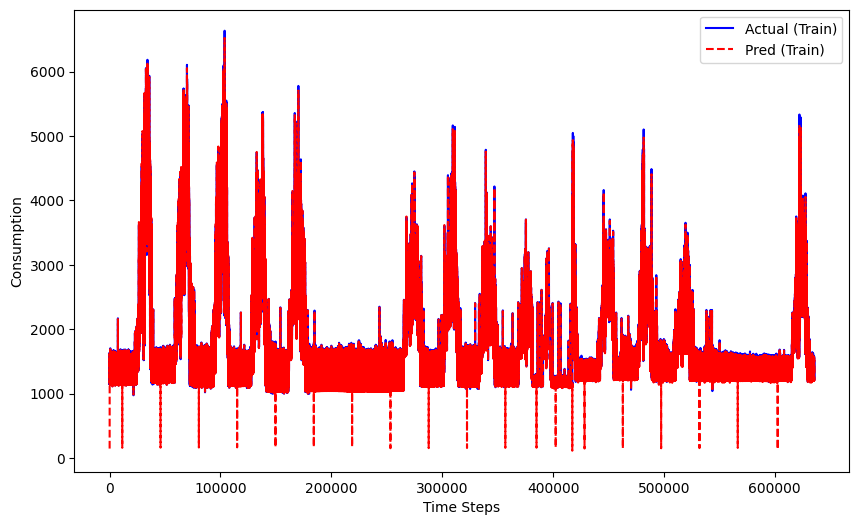

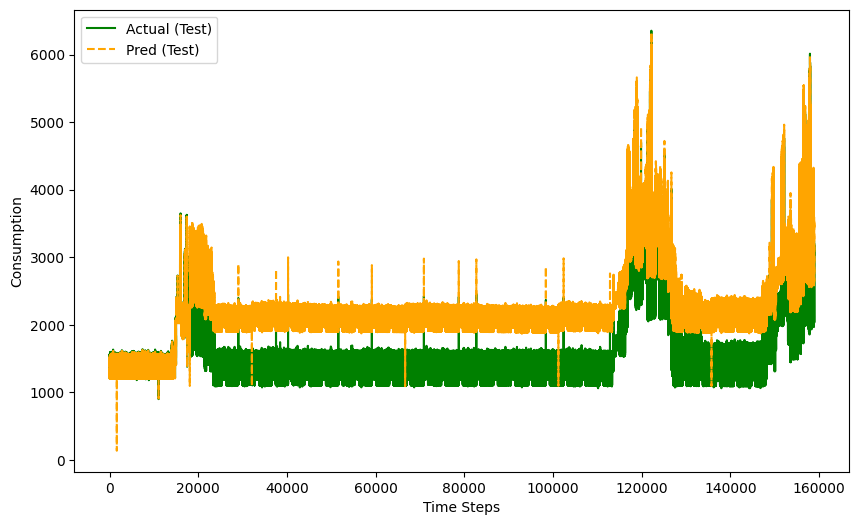

In [13]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_train_inv, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Pred (Train)', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))

plt.plot(y_test_inv, label='Actual (Test)', color='green')
plt.plot(y_test_pred, label='Pred (Test)', linestyle='dashed', color='orange')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


Get Data 

In [14]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from datetime import datetime, timedelta

building_repo = BuildingRepository()
df_test = pd.DataFrame(building_repo.get_power_historic(datetime.now()-timedelta(hours=10)))
df_test = df_test.drop("_id", axis=1)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
# Calculate the datetime for 24 hours ago from the current time
current_time = df_test['datetime'].max()
twenty_four_hours_ago = current_time - timedelta(hours=24)

# Filter the DataFrame to get only the rows for the last 24 hours
last_24_hours_data = df_test[df_test['datetime'] >= twenty_four_hours_ago]

last_24_hours_data['totalpower'] = pd.to_numeric(last_24_hours_data['totalpower'], errors='coerce')
last_24_hours_data['Month'] = last_24_hours_data['datetime'].dt.month
last_24_hours_data['Day'] = last_24_hours_data['datetime'].dt.day
last_24_hours_data['Hour'] = last_24_hours_data['datetime'].dt.hour
last_24_hours_data['Minute'] = last_24_hours_data['datetime'].dt.minute

last_24_hours_data.rename(columns={'totalpower': 'Consumption'}, inplace=True)

last_24_hours_data['datetime'] = pd.to_datetime(last_24_hours_data['datetime'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)
last_24_hours_data.set_index("datetime", inplace=True)
last_24_hours_data = last_24_hours_data.resample('1H').mean()

last_24_hours_data.drop(['totalgeneration'], axis=1, inplace=True)

last_24_hours_data = last_24_hours_data.dropna()
last_24_hours_data['Consumption-1'] = last_24_hours_data['Consumption'].shift(1)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(1), 'Consumption-1'] = 0
last_24_hours_data['Consumption-2'] = last_24_hours_data['Consumption'].shift(2)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(2), 'Consumption-2'] = 0
#last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data

,Month,Day,Hour,Minute,Consumption-1,Consumption-2,Consumption
datetime,,,,,,,
2023-11-07 06:00:00,11.0,7.0,6.0,40.540659,0.000000,0.000000,1435.478022
2023-11-07 07:00:00,11.0,7.0,7.0,29.500000,1435.478022,0.000000,1404.791667
2023-11-07 08:00:00,11.0,7.0,8.0,29.500000,1404.791667,1435.478022,1653.198938
2023-11-07 09:00:00,11.0,7.0,9.0,29.500000,1653.198938,1404.791667,2076.954542
2023-11-07 10:00:00,11.0,7.0,10.0,29.500000,2076.954542,1653.198938,2149.559857
2023-11-07 11:00:00,11.0,7.0,11.0,29.500000,2149.559857,2076.954542,2819.466732
2023-11-07 12:00:00,11.0,7.0,12.0,29.500000,2819.466732,2149.559857,2180.991250
2023-11-07 13:00:00,11.0,7.0,13.0,29.473574,2180.991250,2819.466732,2139.074409
2023-11-07 14:00:00,11.0,7.0,14.0,29.500000,2139.074409,2180.991250,3073.526983


Load model

In [15]:
import joblib

# Load the scaler
scaler_test = joblib.load('training_1/scaler.pkl')
pred_scaler_test = joblib.load('training_1/pred_scaler.pkl')

df_scaled = scaler_test.fit_transform(last_24_hours_data)

print("Len pred", int(len(df_scaled)))

Len pred 11


In [16]:
import numpy as np
timesteps = 1

def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)

X_pred, y = prepare_data(df_scaled, timesteps)

print("X_pred shape", X_pred.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_pred = np.reshape(X_pred, (X_pred.shape[0], timesteps, X_pred.shape[2]))

print("X_pred shape", X_pred.shape, "y_pred shape", y.shape)

X_pred shape (8, 1, 6) timesteps 1
X_pred shape (8, 1, 6) y_pred shape (8,)


In [17]:
model

### load model

In [18]:
import tensorflow as tf

model = tf.keras.models.load_model('saved_model/consumption_forecast')
y_pred = model.predict(X_pred)
y_pred = pred_scaler_test.inverse_transform(y_pred)
y = pred_scaler_test.inverse_transform(y.reshape(-1, 1))

1/1 [==============================] - 0s 278ms/step


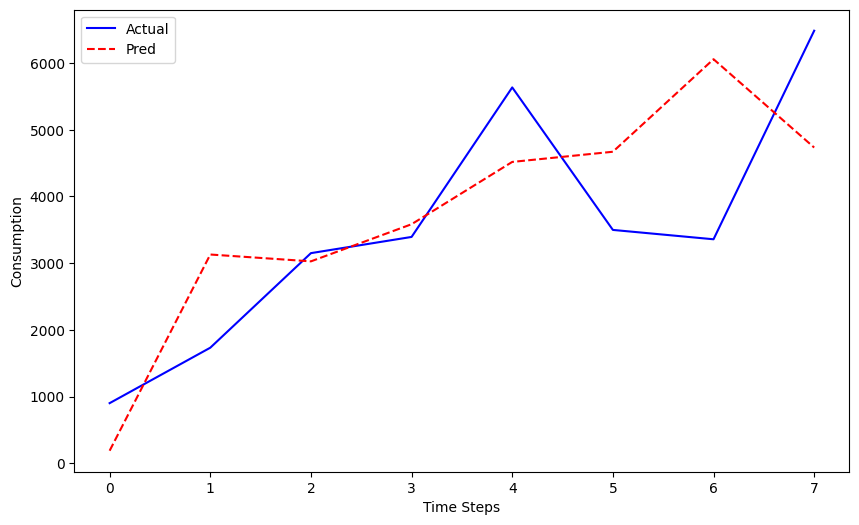

In [19]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_pred, label='Pred', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


In [20]:
last = scaler_test.inverse_transform(df_scaled[:-3])

df = pd.DataFrame(last, columns=['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption'])
df['Prediction'] = y_pred
df['datetime'] = pd.to_datetime(df[['Month', 'Day', 'Hour', 'Minute']].assign(Year=2023))

# Drop the separate columns if needed
df.drop(['Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

df.set_index("datetime", inplace=True)
df = df.resample('1H').mean()
df["datetime"] = df.index
# Now, 'datetime' contains the combined datetime values
df

,Consumption-1,Consumption-2,Consumption,Prediction,datetime
datetime,,,,,
2023-11-07 06:00:00,0.000000,0.000000,1435.478022,187.825577,2023-11-07 06:00:00
2023-11-07 07:00:00,1435.478022,0.000000,1404.791667,3129.442871,2023-11-07 07:00:00
2023-11-07 08:00:00,1404.791667,1435.478022,1653.198938,3026.884277,2023-11-07 08:00:00
2023-11-07 09:00:00,1653.198938,1404.791667,2076.954542,3583.659912,2023-11-07 09:00:00
2023-11-07 10:00:00,2076.954542,1653.198938,2149.559857,4517.625000,2023-11-07 10:00:00
2023-11-07 11:00:00,2149.559857,2076.954542,2819.466732,4670.233398,2023-11-07 11:00:00
2023-11-07 12:00:00,2819.466732,2149.559857,2180.991250,6057.675293,2023-11-07 12:00:00
2023-11-07 13:00:00,2180.991250,2819.466732,2139.074409,4733.265137,2023-11-07 13:00:00
